In [10]:
%run ct_include.ipy
source.name
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


model shape:  [128, 128, 145]


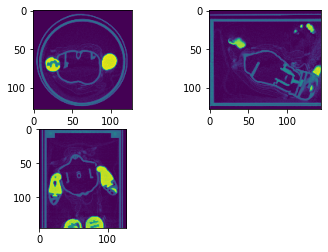

[1.0233599999999998, 1.0233599999999998] 1.0233599999999998
1.0 1.0 1.0
1.0233599999999998


In [206]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import glob



root = os.getcwd()
folder_path = os.path.join(root, 'recon_data_a')
fnames = []
for i in range(1,146):
    file_path = 'recon_data_a_' + "{:04d}".format(i) + '.dcm'
    fnames.append(os.path.join(folder_path, file_path))
    

# load the DICOM files
files = []

#print('glob: {}'.format(sys.argv[1]))
for fname in fnames:
    #print("loading: {}".format(fname))
    files.append(pydicom.dcmread(fname))

#print("file count: {}".format(len(files)))

# skip files with no SliceLocation (eg scout views)
slices = []
skipcount = 0
for f in files:
    if hasattr(f, 'SliceLocation'):
        slices.append(f)    # slices contain all files with this attr
    else:
        skipcount = skipcount + 1

#print("skipped, no SliceLocation: {}".format(skipcount))

# ensure they are in the correct order
slices = sorted(slices, key=lambda s: s.SliceLocation)

# pixel aspects, assuming all slices are the same
ps = slices[0].PixelSpacing
ss = slices[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

# create 3D array
img_shape = list(slices[0].pixel_array.shape)   # shape of one slice
img_shape.append(len(slices))    # shape of one slice * no of slice
print('model shape: ', img_shape)
img3d = np.zeros(img_shape)

# fill 3D array with the images from the files
for i, s in enumerate(slices):
    img2d = s.pixel_array
    img3d[:, :, i] = img2d

# plot 3 orthogonal slices
a1 = plt.subplot(2, 2, 1)
plt.imshow(img3d[:, :, img_shape[2]//2])
a1.set_aspect(ax_aspect)

a2 = plt.subplot(2, 2, 2)
plt.imshow(img3d[:, img_shape[1]//2, :])
a2.set_aspect(sag_aspect)

a3 = plt.subplot(2, 2, 3)
plt.imshow(img3d[img_shape[0]//2, :, :].T)
a3.set_aspect(cor_aspect)

plt.show()
print(ps, ss)
print(ax_aspect, sag_aspect, cor_aspect)
print(files[50].SliceThickness)

In [132]:
def read_dcm(folder_name):
    # return 3d array of hu unit, pixelspacing and slice thickness
    root = os.getcwd()
    folder_path = os.path.join(root, folder_name)
    fnames = []


    for file in os.listdir(folder_path):
        if file.endswith(".dcm"): 
            fname = os.path.join(folder_path, file)
            fnames.append(fname)
      

    # load the DICOM files
    files = []

    #print('glob: {}'.format(sys.argv[1]))
    for fname in fnames:
        #print("loading: {}".format(fname))
        files.append(pydicom.dcmread(fname))

    #print("file count: {}".format(len(files)))

    # skip files with no SliceLocation (eg scout views)
    slices = []
    skipcount = 0
    for f in files:
        if hasattr(f, 'SliceLocation'):
            slices.append(f)    # slices contain all files with this attr
        else:
            skipcount = skipcount + 1

    #print("skipped, no SliceLocation: {}".format(skipcount))

    # ensure they are in the correct order
    slices = sorted(slices, key=lambda s: s.SliceLocation)

    # pixel aspects, assuming all slices are the same
    ps = slices[0].PixelSpacing
    ss = slices[0].SliceThickness


    # create 3D array
    img_shape = list(slices[0].pixel_array.shape)   # shape of one slice
    img_shape.append(len(slices))    # shape of one slice * no of slice
    print('model shape: ', img_shape)
    img3d = np.zeros(img_shape)

    # fill 3D array with the images from the files
    for i, s in enumerate(slices):
        img2d = s.pixel_array
        img3d[:, :, i] = img2d


    return img3d, ps, ss

def plot_3d(img3d, ps, ss,):
    #
    ax_aspect = ps[1]/ps[0]
    sag_aspect = ps[1]/ss
    cor_aspect = ss/ps[0]

    plt.figure(figsize=(15, 15))
    
    # plot 3 orthogonal slices
    a1 = plt.subplot(2, 2, 1)
    plt.imshow(img3d[:, :, img_shape[2]//2])
    a1.set_aspect(ax_aspect)

    a2 = plt.subplot(2, 2, 2)
    plt.imshow(img3d[:, img_shape[1]//2, :])
    a2.set_aspect(sag_aspect)

    a3 = plt.subplot(2, 2, 3)
    plt.imshow(img3d[img_shape[0]//2, :, :].T)
    a3.set_aspect(cor_aspect)

    
    plt.show()
    
    return None

def cylinder_crop(img3d, ratio = 0.9, cut = 2):
    # cut = 2 means img3d[:, :, xxx] xxx will be cropped
    if cut == 2:
        length, width = img3d.shape[0], img3d.shape[1]
    elif cut == 1:
        length, width = img3d.shape[0], img3d.shape[2]
    elif cut == 0:
        length, width = img3d.shape[1], img3d.shape[2]

    radius = int(min(length, width)/2 * ratio) # radius of cropped circle
    xi, yi = np.meshgrid(np.arange(0,length,1) - (length/2) + 0.5, np.arange(0,width,1) - (width/2) + 0.5)
    img3d[np.where((xi ** 2 + yi ** 2) > radius**2)] = -1000 # -1000 is HU of air
        
    return img3d

def straight_crop(img3d, ratio = 0.9, cut = 2):
    n = int(img3d.shape[cut]*(1-ratio))
    if cut == 2: 
        img3d[:, :, :n] = -1000
    elif cut == 1: 
        img3d[:, :n, :] = -1000
    elif cut == 0: 
        img3d[:n, :, :] = -1000

    return img3d

model shape:  [128, 128, 145]


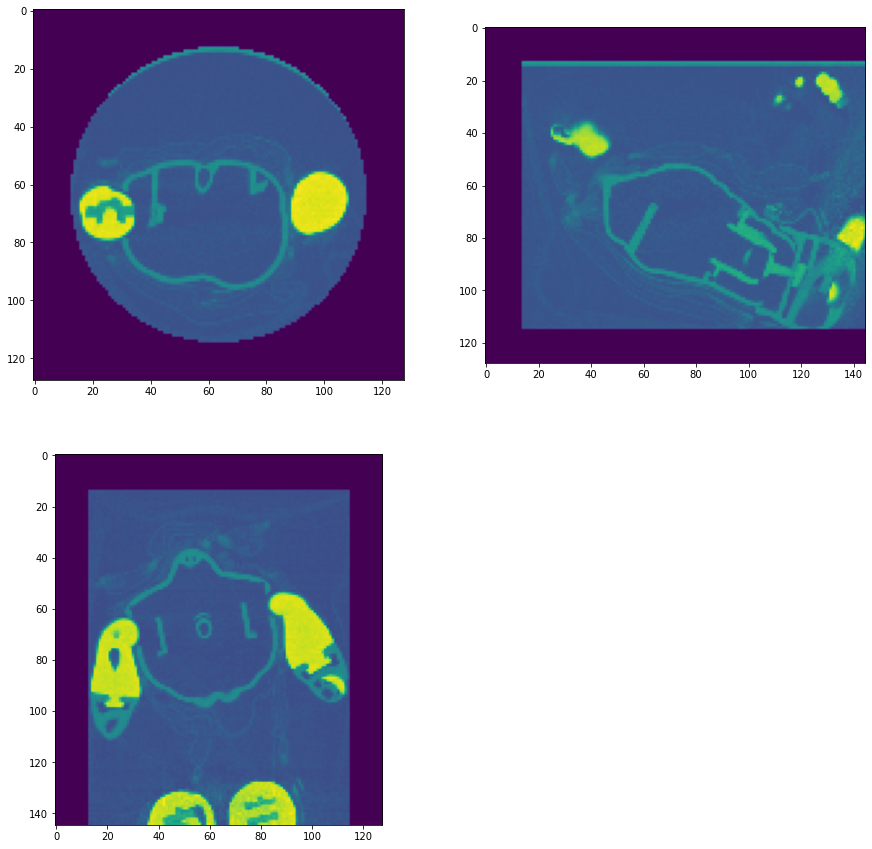

[-1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000.
 -1000. -1000. -1000. -1000. -1000.   175.   117.   110.     0.     2.
    58.    29.    94.     0.    18.    19.    23.    26.   107.   129.
    92.   109.    93.    87.   174.    62.   119.    77.   127.   168.
   148.   166.   130.   174.    85.   131.   206.   180.   220.   256.
   279.   282.   216.   205.   202.   112.    60.    83.    86.    86.
   109.    96.   245.   255.   165.    57.    75.    72.    38.   122.
   134.    93.    56.   112.    14.    32.   133.   261.    71.   164.
   268.    73.   168.   143.   134.   168.   138.   269.   121.    77.
     9.   138.    83.    19.    35.    70.    74.    43.    55.    42.
    83.    42.    58.    81.    67.    29.    82.    45.    24.    37.
     7.    36.    60. -1000. -1000. -1000. -1000. -1000. -1000. -1000.
 -1000. -1000. -1000. -1000. -1000. -1000. -1000. -1000.]


In [133]:
img3d, ps, ss = read_dcm('recon_data_a')
img3d = cylinder_crop(img3d, ratio = 0.8)
img3d = straight_crop(img3d, ratio = 0.9)
plot_3d(img3d, ps, ss,)

#print(img3d[:, :, img_shape[2]//2][50])

In [163]:
def hu_to_u(hu, mev = 0.06):
    n = int((mev*0.7)//0.001)
    u_water = material.coeff('Water')[n]
    u_air = material.coeff('Air')[n]
    #print(n,u_water, u_air)
    u = hu / 1000 * (u_water - u_air) + u_water
    return u

u3d = hu_to_u(img3d)




4.470719277800301 -0.0629845767228963


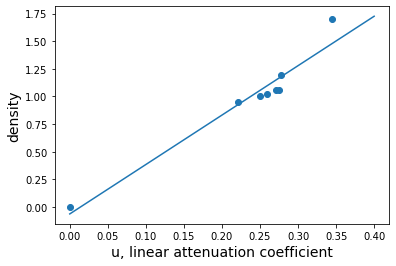

In [190]:
def fit_u_density():
    density =[0.001205, 0.95, 1.06, 1.02, 1, 1.06, 1.92, 4.54, 8.9, 7.18, 7.874, 1.7, 8.902, 7.44, 2.699, 8.96, 1.19]
    u = []
    n = int((0.06*0.7)//0.001)
    for name in material.name:
        if name != 'Co-Cr' and name != 'Stainless Steel':
            u.append(material.coeff(name)[n])

    u_water = material.coeff('Water')[n]
    u_air = material.coeff('Air')[n]

    hu = 1000* (np.array(u) -u_water)/(u_water - u_air)

    density.sort()
    hu.sort()
    u.sort()
    # metals have very different relationship... nelect
    density = density[:8]
    hu = hu[:8]
    u = u[:8]
   
    plt.scatter(u, density)

    m, b =np.polyfit(u, density, 1)

    t = np.linspace(0, 0.4, 100)
    y = m*t+b
    plt.plot(t, y)
    plt.xlabel('u, linear attenuation coefficient', fontsize = 14)
    plt.ylabel('density', fontsize = 14)
    print(m, b)
    return m, b

m, b = fit_u_density()


In [212]:
density3d = m * u3d + b
unit_volume = ss * ps[0] * ps[1]

mass = np.sum(density3d) * unit_volume
print(ps, ss)
print(mass, 'gram')
'''
slice thickness, pixel size are both 1.02 cm according to dicom file
this is much larger than it should be (actual size will be 2 meter tall then)
find out how ss and ps correspond to real life length
'''

[1.0233599999999998, 1.0233599999999998] 1.0233599999999998
1625619.655389952 gram


'\nslice thickness, pixel size are both 1.\n'